In [107]:
import numpy   as np
import nibabel as nb
import matplotlib.pyplot as plt
import random
import os
import nibabel as nib #to read the niftis
from glob import glob #to quicly read the nifti paths
%matplotlib notebook


In [108]:
# Circles

In [130]:
X = 128
Y = 128
Z = 64
vol_size = [X, Y, Z]
output_path = '/home/diffusion/Dropbox/Documents/CHUV/ASAP/FederatedLearning/fedem/data/synthetic_3d/'

In [131]:
grid = np.array([[row, col, z] for row in range(X) for col in range(Y) for z in range(Z)])



In [132]:

max_spheres = 10;
max_rad = 40
min_rad = 10


def createSphereImages(output_path,num_images,max_spheres,max_rad,min_rad):

    
    for j in range(num_images):
        vol_0 = np.zeros(vol_size).ravel()
        num_spheres = random.randrange(3,max_spheres+1)
        
        for i in range(num_spheres):
            x = random.randrange(1,X)
            y = random.randrange(1,Y)
            z = random.randrange(1,Z)
            rad = random.randrange(min_rad,max_rad+1)
            intentsity = random.uniform(0.1,1)
            center = np.array([x,y,z])
            distance = grid - center 
            sphere_mask = np.linalg.norm(distance,axis=1) <= rad
            vol_0[sphere_mask]= intentsity
        vol_0 = np.reshape(vol_0,(X,Y,Z))

        nb.save(nb.Nifti1Image(vol_0,np.eye(4)),os.path.join(output_path,f'sphere_img{j}.nii.gz'))
        nb.save(nb.Nifti1Image((vol_0>0).astype(int),np.eye(4)),os.path.join(output_path,f'sphere_seg{j}.nii.gz'))

In [133]:
#train
#createSphereImages(output_path+'/train',50,max_spheres,max_rad,min_rad)
#test
#createSphereImages(output_path+'/test',20,max_spheres,max_rad,min_rad)
#val
#createSphereImages(output_path+'/val',20,max_spheres,max_rad,min_rad)

In [134]:
# Squares

In [135]:
max_cubes= 100;
shape_size = 1
scale_size = 5
def createCubesImages(output_path,num_images,max_cubes,shape_size=1,scale_size=5,min_size=3):

    for j in range(num_images):
        vol_0 = np.zeros(vol_size).ravel()
        num_cubes = random.randrange(50,max_cubes)

        for i in range(num_cubes):
            x = random.randrange(1,X)
            y = random.randrange(1,Y)
            z = random.randrange(1,Z)

            size =  np.random.gamma(shape_size,scale_size) + min_size

            intentsity = random.uniform(0.1,1)
            center = np.array([x,y,z])
            distance = abs(grid - center)
            cubes_mask = np.sum(distance<size,axis=1) == 3
            vol_0[cubes_mask]= intentsity
        vol_0 = np.reshape(vol_0,(X,Y,Z))

        nb.save(nb.Nifti1Image(vol_0,np.eye(4)),os.path.join(output_path,f'cubes_img{j}.nii.gz'))
        nb.save(nb.Nifti1Image((vol_0>0).astype(int),np.eye(4)),os.path.join(output_path,f'cubes_seg{j}.nii.gz'))
          

In [136]:
#train
createCubesImages(output_path+'/train',1,max_cubes)

#val
#createCubesImages(output_path+'/val',20,max_cubes)

#test
#createCubesImages(output_path+'/test',20,max_cubes)

# Noisy Dataset

In [138]:

def add_additive_gaussian_noise(img,mu=0,sigma=0.1):
    '''
    :param img: input image to add noise on
    :param mu: mean of the gaussian noise model
    :param sigma: sigma of the gaussian noise model
    :return: img_noise, the noisy image
    '''
    # Generate random gaussian noise with specified mean and sigma values
    noise = np.random.normal(mu, sigma, img.shape)

    # Add generated noise to input image
    img_noise = np.add(img,noise)

    # Clip noisy image between 0-255
    img_noise[img_noise < 0] = 0
    img_noise[img_noise > 1] = 1

    return img_noise


def add_additive_rician_noise(img,mu=0,sigma=0.1):
    '''
    :param img: input image to add noise on
    :param mu: mean of the gaussian noise model
    :param sigma: sigma of the gaussian noise model
    :return: img_noise, the noisy image
    '''

    # Generate random gaussian noise with specified mean and sigma values
    noise = np.random.normal(mu, sigma, img.shape)
    
    # Generate random gaussian noise with specified mean and sigma values
    inoise = np.random.normal(mu, sigma, img.shape)
    inoise*=inoise;
    # Add generated noise to input image
    real_val = np.add(img,noise)
    
    img_noise = np.sqrt(((real_val*real_val) + inoise))

    # Clip noisy image between 0-255
    img_noise[img_noise < 0] = 0
    img_noise[img_noise > 1] = 1

    return img_noise

In [139]:
X = 128
Y = 128
Z = 64
vol_size = [X, Y, Z]
input_path = '/home/diffusion/Dropbox/Documents/CHUV/ASAP/FederatedLearning/fedem/data/synthetic_3d/'

# train 

In [140]:
train = sorted(glob(input_path+'train/'+'cubes*img*') + glob(input_path+'train/'+'sphere*img*')) 

In [145]:

for path_ in train:
    img_ = nb.load(path_).get_fdata()
    img_noisy = add_additive_rician_noise(img_,sigma=0.05)
    new_path = path_.replace('train','train_noisy')
    nb.save(nb.Nifti1Image(img_noisy,np.eye(4)),new_path)


<IPython.core.display.Javascript object>


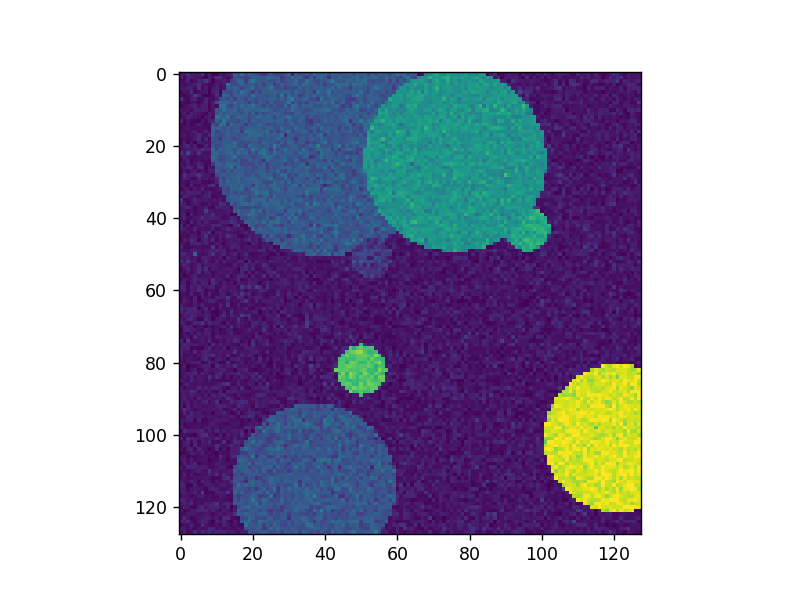

In [148]:
plt.figure()
plt.imshow(img_noisy[:,:,30])

# test

In [152]:
test = sorted(glob(input_path+'test/'+'cubes*img*') + glob(input_path+'test/'+'sphere*img*')) 

In [155]:

for path_ in test:
    img_ = nb.load(path_).get_fdata()
    img_noisy = add_additive_rician_noise(img_,sigma=0.05)
    new_path = path_.replace('test','test_noisy')
    nb.save(nb.Nifti1Image(img_noisy,np.eye(4)),new_path)


<IPython.core.display.Javascript object>


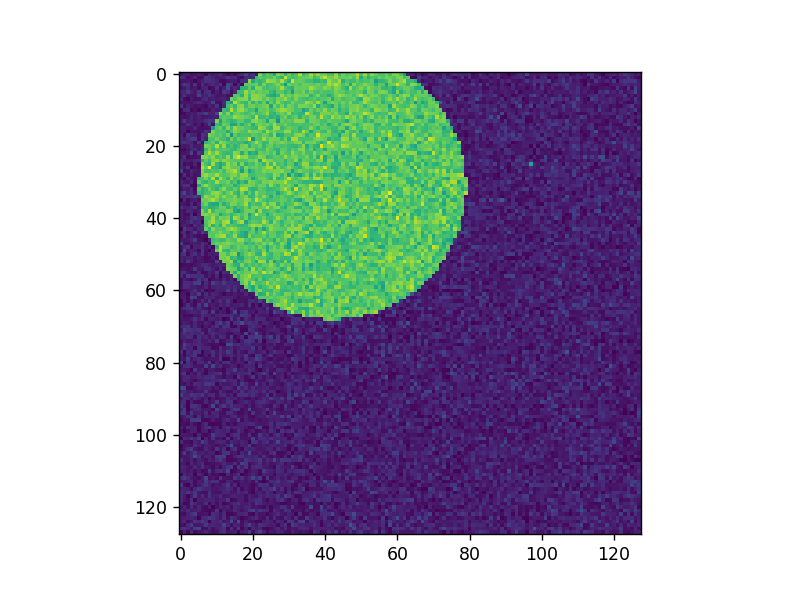

In [156]:
plt.figure()
plt.imshow(img_noisy[:,:,30])

#Validation

In [166]:
val = sorted(glob(input_path+'val/'+'cubes*img*') + glob(input_path+'val/'+'sphere*img*')) 

In [167]:

for path_ in val:
    img_ = nb.load(path_).get_fdata()
    img_noisy = add_additive_rician_noise(img_,sigma=0.05)
    new_path = path_.replace('val','val_noisy')
    nb.save(nb.Nifti1Image(img_noisy,np.eye(4)),new_path)


<IPython.core.display.Javascript object>


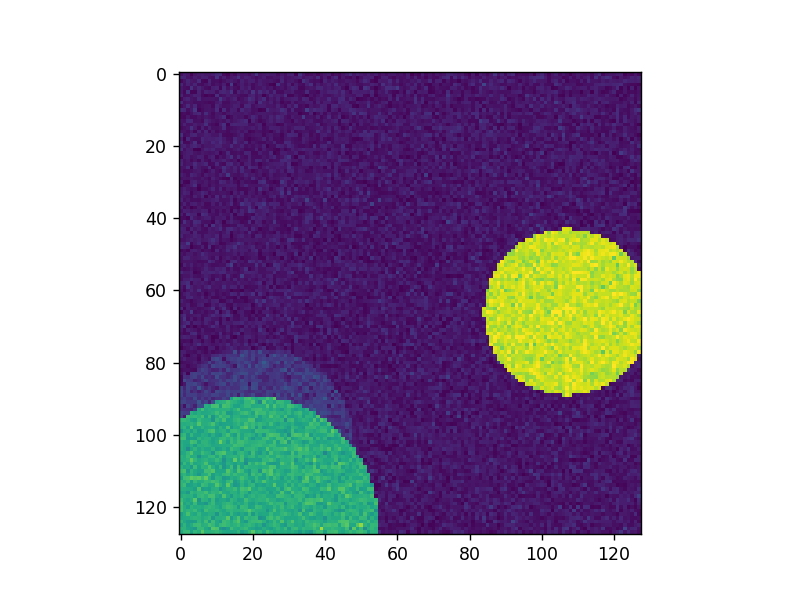

In [168]:
plt.figure()
plt.imshow(img_noisy[:,:,30])